In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt

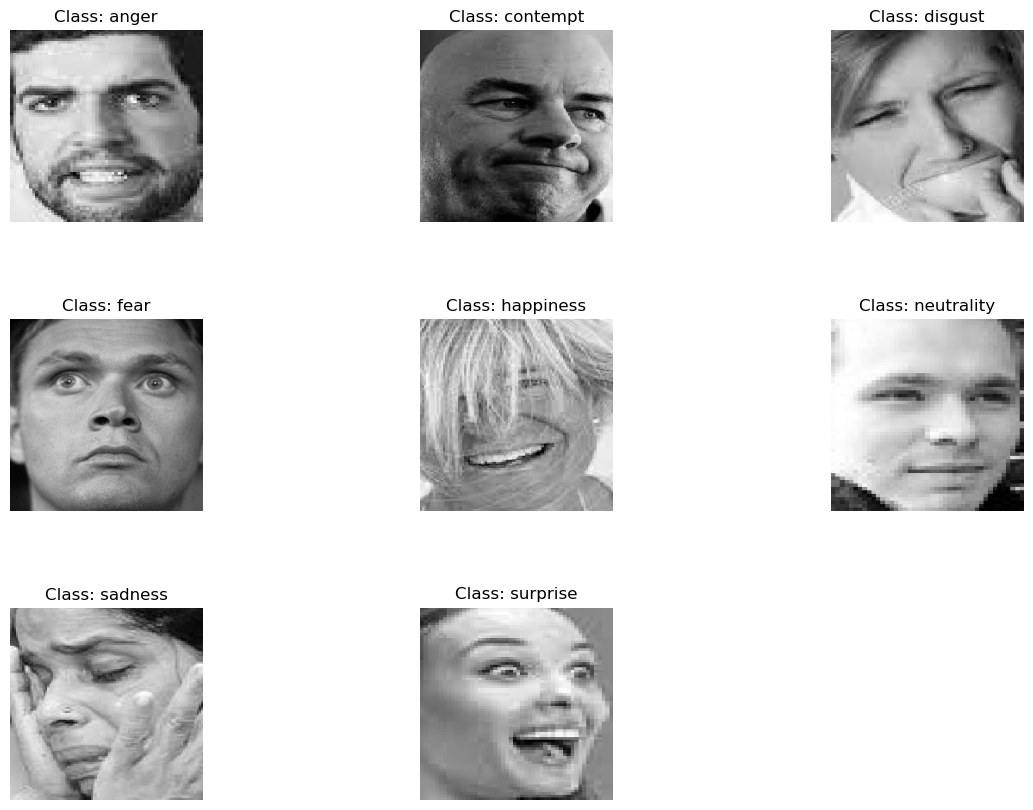

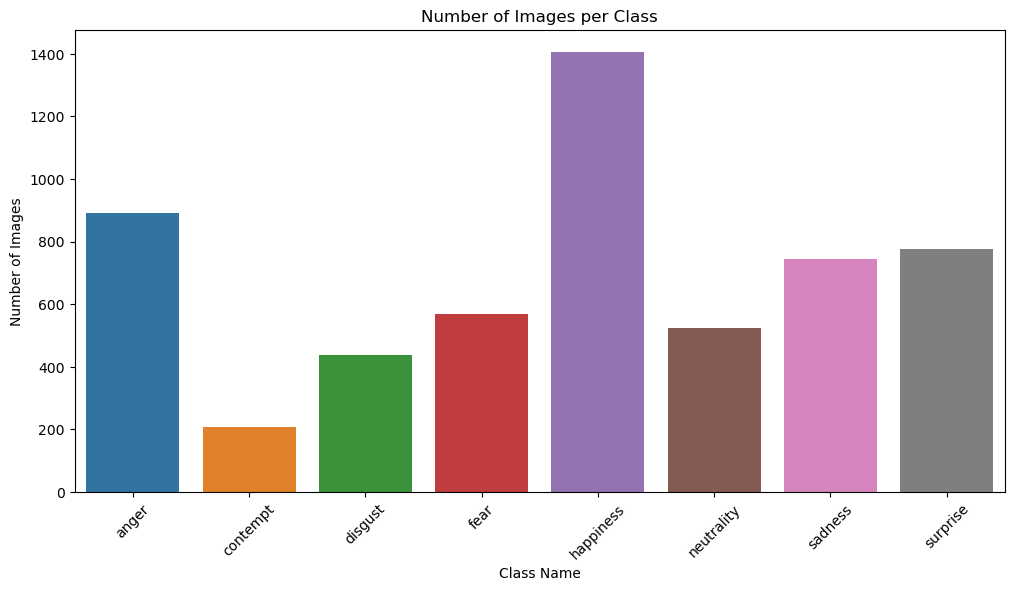

In [2]:
import random
from PIL import Image
import seaborn as sns

data_dir = 'data_for_emotion_recognition/'
class_names = os.listdir(data_dir)
class_counts = {}
rows = len(class_names) // 3 + (len(class_names) % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    image_file = random.choice(image_files)
    image_path = os.path.join(class_dir, image_file)
    image = Image.open(image_path)
    image = image.convert('L')
    ax = axes[i // 3, i % 3]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Class: {class_name}')
    ax.axis('off')  
    
    class_counts[class_name] = len(image_files)

if len(class_names) % 3 != 0:
    for i in range(len(class_names), rows * 3):
        fig.delaxes(axes[i // 3, i % 3])

plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        return sum(len(files) for _, _, files in os.walk(self.root_dir))

    def __getitem__(self, idx):
        class_idx = 0
        while idx >= len(os.listdir(os.path.join(self.root_dir, self.classes[class_idx]))):
            idx -= len(os.listdir(os.path.join(self.root_dir, self.classes[class_idx])))
            class_idx += 1

        img_class = self.classes[class_idx]
        img_name = os.listdir(os.path.join(self.root_dir, img_class))[idx]
        img_path = os.path.join(self.root_dir, img_class, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, class_idx

# Define the validation dataset
val_dataset = EmotionDataset(root_dir='data/', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 32
train_dataset = EmotionDataset(root_dir='data/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Epoch [1/25] Loss: 1.5490849758016652 Train Acc: 43.61% Val Acc: 49.46%
Epoch [2/25] Loss: 1.2224817878898533 Train Acc: 54.68% Val Acc: 63.04%
Epoch [3/25] Loss: 1.0826410404567062 Train Acc: 60.56% Val Acc: 65.29%
Epoch [4/25] Loss: 0.9539619824667086 Train Acc: 65.19% Val Acc: 77.07%
Epoch [5/25] Loss: 0.7631644949145701 Train Acc: 72.53% Val Acc: 79.59%
Epoch [6/25] Loss: 0.6012096798968041 Train Acc: 78.43% Val Acc: 81.03%
Epoch [7/25] Loss: 0.44840463649096163 Train Acc: 83.79% Val Acc: 88.22%
Epoch [8/25] Loss: 0.3206781008462796 Train Acc: 89.29% Val Acc: 95.50%
Epoch [9/25] Loss: 0.23892866841506685 Train Acc: 92.08% Val Acc: 94.06%
Epoch [10/25] Loss: 0.1705540391862735 Train Acc: 94.84% Val Acc: 96.76%
Epoch [11/25] Loss: 0.1528856454459929 Train Acc: 95.32% Val Acc: 96.13%
Epoch [12/25] Loss: 0.11953871529121166 Train Acc: 96.15% Val Acc: 98.11%
Epoch [13/25] Loss: 0.11629469054162331 Train Acc: 96.37% Val Acc: 97.48%
Epoch [14/25] Loss: 0.09330037821635562 Train Acc: 97.30

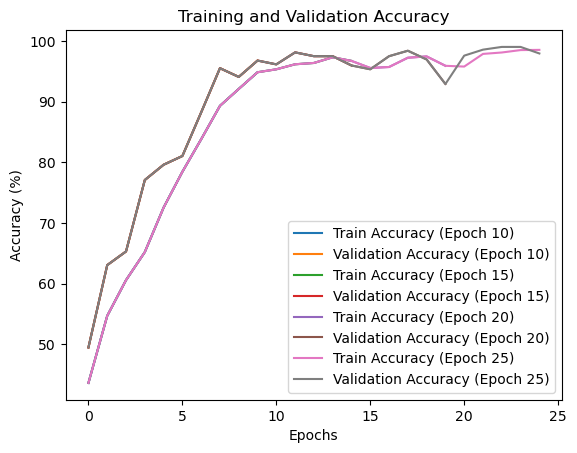

In [11]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        num_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        return x
num_classes = len(train_dataset.classes)
model = EmotionCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Lists to store training and validation accuracy at each epoch
train_acc_list = []
val_acc_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 25
# Training loop
for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
    running_loss = 0.0
    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_acc_list.append(train_accuracy)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_acc_list.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)} "
          f"Train Acc: {train_accuracy:.2f}% Val Acc: {val_accuracy:.2f}%")

    # Plot the accuracy at specified epochs
    if epoch + 1 in [10, 15, 20,25]:
        plt.plot(train_acc_list, label=f'Train Accuracy (Epoch {epoch + 1})')
        plt.plot(val_acc_list, label=f'Validation Accuracy (Epoch {epoch + 1})')

print("Training finished")

# Plot the training and validation accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
